## ДЗ 2. Панков Викентий

# Часть 1.
## 1. Покрытие генома

### Выравнивание и расчёт статистики покрытия генома (samtools): 

bwa index 2a_ref.fasta  
bwa mem 2a_ref.fasta frag.R1.fastq frag.R2.fastq > frag.sam  
samtools flagstat frag.sam  
samtools view -Sb frag.sam > frag.bam  
samtools sort frag.bam > frag_sorted.bam  
samtools index frag_sorted.bam  
samtools depth frag_sorted.bam > frag_coverage.txt  





### График и статистика покрытия генома

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plotGenomeCoverage(fileName, avgWindow):
    df = pd.read_csv(fileName, sep="\t", usecols=[1,2], header=None)
    df = df.rename(columns = {1: "genome_position", 2: "depth"})
    df_averaged = df.groupby(np.arange(len(df))//avgWindow).mean()

    df_averaged.plot(x="genome_position", y="depth")
    plt.ylabel("Coverage")
    plt.xlabel("Genome position")
    plt.title("Genome coverage")

    print(f"Среднее покрытие: {int(df.depth.mean())}")
    print(f"Доля покрытой области генома: {df.depth[df.depth>0].count()/len(df)*100}%")

**Для первого датасета:**

Среднее покрытие: 70
Доля покрытой области генома: 100.0%


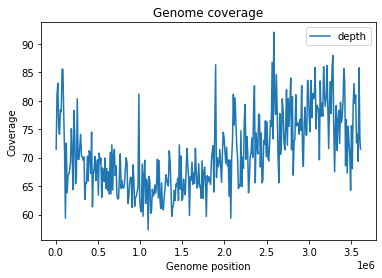

In [4]:
plotGenomeCoverage("data/HW2/test/frag_coverage.txt", 10000)

## 2. Статистика и распределение расстояния вставки

 samtools stats test_sorted.bam | grep ^IS | cut -f 2- > insertsizes.txt

In [7]:
def plotInsertSizes(insertSizesDataFileName):
    df = pd.read_csv(insertSizesDataFileName, sep="\t", usecols=[0,1], header=None)
    df = df.rename(columns = {0: "insert_size", 1: "pairs_total"})
    df.plot(x="insert_size", y="pairs_total")
    plt.ylabel("Reads")
    plt.xlabel("Insert size")
    plt.title("Insert sizes distribution")
    
    mean = (df.insert_size*df.pairs_total).sum()/df.pairs_total.sum()
    print(f"Среднее расстояние вставки: {mean}")
    std = np.sqrt(np.cov(df.insert_size, aweights=df.pairs_total))
    print(f"Среднеквадратичное отклонение: {std}")
    print(f"95% доверительный интервал: ({mean - 2*std}, {mean + 2*std})")

**Для первого датасета:**

Среднее расстояние вставки: 267.8993735231801
Среднеквадратичное отклонение: 61.317930507880064
95% доверительный интервал: (145.26351250741996, 390.53523453894024)


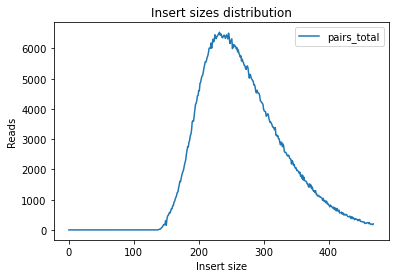

In [6]:
plotInsertSizes("data/HW2/test/frag_insertsizes.txt")

** Для второго датасета **

Среднее расстояние вставки: 7255.044615439186
Среднеквадратичное отклонение: 1218.199717350198
95% доверительный интервал: (4818.645180738789, 9691.444050139582)


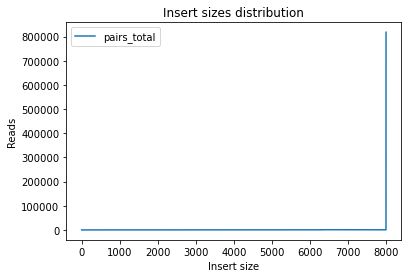

In [19]:
plotInsertSizes("data/HW2/test/jump_insertsizes.txt")

## 3. Частоты различных замен

In [13]:
import pysam
from Bio import SeqIO
from collections import Counter

def getSubsMatrix(referenceFileName, alignmentFileName):

    subsMatrix = np.zeros(shape =(4,4))

    symMap = {"A":0,"C":1,"G":2,"T":3,"a":0,"c":1,"g":2,"t":3}

    samfile = pysam.AlignmentFile(alignmentFileName, "rb" )

    seqIo = list(SeqIO.parse(referenceFileName, "fasta"))

    for pileupcolumn in samfile.pileup():
        ref_pos = pileupcolumn.reference_pos
        ref_base = seqIo[pileupcolumn.reference_id].seq[ref_pos]

        counts = Counter(pileupcolumn.get_query_sequences())
        for key in counts.keys():
            if(key!='' and key!='N' and key!='n'):
                subsMatrix[symMap[key], symMap[ref_base]] += counts[key]

    matrix = pd.DataFrame(subsMatrix, dtype=int)
    matrix.index = ["A","C","G","T"]
    matrix.columns = ["A","C","G","T"]
    return (matrix)

** Матрица замен для первого датасета: **

In [14]:
getSubsMatrix("data/HW2/test/2a_ref.fasta", "data/HW2/test/frag_sorted.bam")

,A,C,G,T
A,31359550,215863,84751,42182
C,506854,79921031,387990,296384
G,274393,369625,80211733,505720
T,37085,80838,190162,31246016


** Матрица замен для второго датасета: **

In [18]:
getSubsMatrix("data/HW2/test/2a_ref.fasta", "data/HW2/test/jump_sorted.bam")

,A,C,G,T
A,59238799,128229,65775,39099
C,774816,137982048,426529,448806
G,457471,432730,138699785,786418
T,39056,66434,128910,59183335


# Часть 2.
## 2.1. Статистика ридов IonTorrent


### Выравнивание утилитой bwa mem

bwa index ion_reference.fasta  
bwa mem ion_reference.fasta B22-730.fastq > ion.sam  
** 489459 + 0 mapped (98.41% : N/A) **  
samtools view -Sb ion.sam > ion.bam  

samtools stats ion_sorted.bam > ion_stats.txt  

samtools stats ion_sorted.bam | grep ^ID | cut -f 2- > ion_indels.txt

samtools index ion_sorted.bam

Среднее покрытие: 33
Доля покрытой области генома: 99.98796450039767%


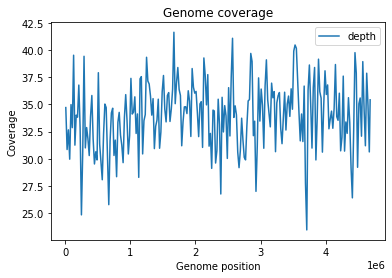

In [49]:
plotGenomeCoverage("data/HW2/test/ion_coverage.txt", 20000)

Средний процент ошибок в ридах (*поле `error rate` в результатах `samtools stats`*): $6.695761e-03$

## Статистика длин инделов

Text(0.5, 1.0, 'Indels distribution')

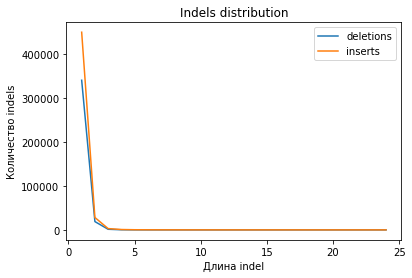

In [56]:
df = pd.read_csv("data/HW2/test/ion_indels.txt", sep="\t", usecols=[0,1,2], header=None)
df = df.rename(columns = {0: "length", 1: "inserts", 2:"deletions"})
df.plot(x="length", y=["deletions","inserts"])

plt.ylabel("Количество indels")
plt.xlabel("Длина indel")
plt.title("Indels distribution")

## Матрица замен, длина инделов в зависимости от длины гомополимерного участка и статистика ошибочных вставок/замен

<span style="color: red;"> TODO: длина инделов в зависимости от длины гомополимерного участка * </span>

In [88]:
import re

homopolymers = [] 

for nucl in ['A','C','T','G']:
    pattern = re.compile(nucl + "{10,}")
    for record in SeqIO.parse("data/HW2/test/ion_reference.fasta", "fasta"):
        for match in pattern.finditer(str(record.seq).upper()):
            homopolymers.append((match.start(), match.end()))

In [21]:
def ionMainStats(referenceFileName, alignmentFileName):
    subsMatrix = np.zeros(shape =(5,5))

    symMap = {"A":0,"C":1,"G":2,"T":3,"a":0,"c":1,"g":2,"t":3,'_':4}

    samfile = pysam.AlignmentFile(alignmentFileName, "rb" )

    seqIo = list(SeqIO.parse(referenceFileName, "fasta"))

    insertQualities = []
    mismatchQualities = []

    for pileupcolumn in samfile.pileup():

        ref_pos = pileupcolumn.reference_pos
        ref_base = seqIo[pileupcolumn.reference_id].seq[ref_pos]
        querySequences = pileupcolumn.get_query_sequences(add_indels = True)
        queryQualities = pileupcolumn.get_query_qualities()

        queriesAndQualities = zip(queryQualities, querySequences)
        curInsertQualities = [i for (i,j) in queriesAndQualities if "-" in j]
        if(len(curInsertQualities) > 0):
            insertQualities.extend(curInsertQualities)

        queriesAndQualities = zip(queryQualities, pileupcolumn.get_query_sequences(add_indels = False))
        curMismatchQualities = [i for (i,j) in queriesAndQualities if j!=ref_base]
        if(len(curMismatchQualities) > 0):
            mismatchQualities.extend(curMismatchQualities)

        counts = Counter(querySequences)
        for key in counts.keys():

            if("-" in key):
                subsMatrix[symMap["_"], symMap[key[0]]] += counts[key]
            elif("+" in key):
                subsMatrix[symMap[key[-1]], symMap["_"]] += counts[key]
            elif("*" not in key):
                subsMatrix[symMap[key], symMap[ref_base]] += counts[key]

    matrix = pd.DataFrame(subsMatrix, dtype=int)
    matrix.index = ["A","C","G","T", '_']
    matrix.columns = ["A","C","G","T", '_']

    print(f"Качество нуклеотидов при ошибочных вставках: mean: {np.mean(insertQualities)}, std: {np.std(insertQualities)}" )
    print(f"Качество нуклеотидов при ошибочных заменах: mean: {np.mean(mismatchQualities)}, std: {np.std(mismatchQualities)}" )
    print("")
    print("Матрица замен:")

    return matrix

ionMainStats("data/HW2/test/ion_reference.fasta","data/HW2/test/ion_sorted.bam")

Качество нуклеотидов при ошибочных вставках: mean: 20.04586108650676, std: 5.599432252267291
Качество нуклеотидов при ошибочных заменах: mean: 25.92765312744701, std: 6.830821413153504

Матрица замен:


,A,C,G,T,_
A,39004120,6798,13630,7566,142490
C,6206,38685257,4715,20799,59629
G,20235,5290,38532132,6149,60663
T,7446,13109,6992,38989619,145526
_,68257,76266,109526,58678,0


## 2.2. Построим таблицу частот замен/вставок/удалений и покрытие генома с использованием другого выравнивателя (bowtie2)

bowtie2-build ion_reference.fasta ion_reference  
bowtie2 -x ion_reference -U B22-730.fastq -S ion_bowtie.sam

In [22]:
ionMainStats("data/HW2/test/ion_reference.fasta","data/HW2/test/ion_bowtie_sorted.bam")

Качество нуклеотидов при ошибочных вставках: mean: 20.11065415674385, std: 5.611716861036288
Качество нуклеотидов при ошибочных заменах: mean: 24.912931923347347, std: 7.155496837859464

Матрица замен:


,A,C,G,T,_
A,38818469,25503,31250,25736,149721
C,22048,38517846,21355,36076,65256
G,35576,22083,38328590,21787,65706
T,25573,30291,25911,38807443,153056
_,68587,76701,109618,58765,0


Среднее покрытие: 33
Доля покрытой области генома: 100.0%


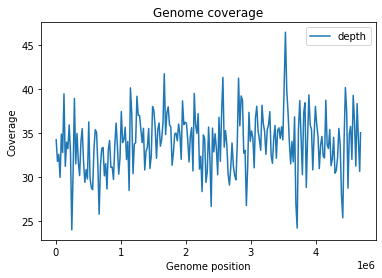

In [23]:
plotGenomeCoverage("data/HW2/test/ion_bowtie_coverage.txt", 20000)

Средний процент ошибок в ридах (*поле `error rate` в результатах `samtools stats`*): $9.349791e-03$

** По сравнению с первым выравнивателем, ошибок в ридах стало в $1.4$ раза больше, а также незначительно (на 1%) упало качество прочтений нуклеотидов при ошибочных заменах **